In [155]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.linalg as la

from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader
import time
from gensim.models import Word2Vec
from collections import defaultdict
from utils.preprocess import add_fragments
from molecules.conversion import (
    mols_from_smiles, mol_to_smiles, mols_to_smiles, canonicalize)

from torch.autograd import Variable
from learner.trainer import Trainer
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import random
from rdkit.Chem import Draw
import time
import random
import gc
from molecules.fragmentation import join_molecules
from rdkit.Chem import Crippen, QED
from molecules.sascorer.sascorer import calculateScore
from sklearn.metrics import r2_score
from IPython.display import clear_output

# Load Model

In [156]:
# paste the file directory from your local storage, it is vital that for the model selected, you edit the model name, for example: 
# 2022-11-24@143425-LAPTOP-E1483HNR-CHEMBL-logP-SAS-recurse-r-short-1-layer-decode-01-KL-20-epoch-100-hidden-size-OUR-MODEL
# becomes: '2022-11-24@143425-LAPTOP-E1483HNR-CHEMBL' in the local storage
# replace the  symbol with ':' and then simply paste that in the directory below:
file_dir = 'RUNS/2024-02-07@19-22-35-LAPTOP-E1483HNR-ZINC/'
config = pickle.load(open(file_dir + 'config/config.pkl', "rb"))
vocab = pickle.load(open(file_dir + 'config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
load_last = True
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

Vocab created/loaded. Size: 646. Effective size: 646. Time elapsed: 00:00:00.
loading last.pt at epoch 10...


In [157]:
model

Frag2Mol(
  (embedder): Embedding(646, 100)
  (latent2rnn): Linear(in_features=512, out_features=512, bias=True)
  (encoder): Encoder(
    (rnn): GRU(100, 512, num_layers=5, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=512, out_features=512, bias=True)
    (rnn2logv): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(100, 512, num_layers=5, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=512, out_features=646, bias=True)
  )
  (latent2hidden): LatentToHidden(
    (latent2hidden): Linear(in_features=512, out_features=2560, bias=True)
  )
)

# Running the training set through the model for latent space and box plots

In [158]:
loader = dataset.get_loader()
data_sample = []
data_sample_correct = []

Data loaded. Size: 38023. Time elapsed: 00:00:00.


In [159]:
#run the training set through the final model
counter = 0
for idx, (src, tgt, lengths, data, tgt_str) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z = model.forward(src, lengths)
    
    #get correct id
    tgt_str_lst = [vocab.translate(target_i) for target_i in tgt.cpu().detach().numpy()]
    target_str_ls_2 = [" ".join(vocab.translate(target_i)) for target_i in tgt.cpu().detach().numpy()]
    src_str_ls_2 = [vocab.translate(target_i) for target_i in src.cpu().detach().numpy()]
    molecules = dataset.data.iloc[list(data)]
    data_index_correct = [molecules[molecules['fragments'] == target_str_ls_2_i].index.values[0] for target_str_ls_2_i in target_str_ls_2]
    molecules_correct = dataset.data.iloc[data_index_correct]
    data_sample_correct.append(data_index_correct)
            
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        z_stack = z.detach().cpu().numpy()
        mu_stack = mu.detach().cpu().numpy()
    else:
        z_stack = np.concatenate((z_stack,z.detach().cpu().numpy()),0)
        mu_stack = np.concatenate((mu_stack, mu.detach().cpu().numpy()), 0)
    counter += 1
    if counter % 500 == 0:
        print(len(mu_stack))
        print(z_stack.shape)
        torch.cuda.empty_cache()

8000
(8000, 512)
16000
(16000, 512)
24000
(24000, 512)
32000
(32000, 512)


In [160]:
# Convert the numpy array to a PyTorch tensor
z_stack = torch.from_numpy(z_stack)
mu_stack = torch.from_numpy(mu_stack)

## Training set

In [161]:
data_sample_index_correct = [item for sublist in data_sample_correct for item in sublist]
data_sample_index_correct_pd = pd.DataFrame(data_sample_index_correct)
data_sample_index_correct_pd.to_csv(file_dir + 'data_sample_index_correct.csv', index=False)

In [162]:
torch.save(mu_stack.detach(), file_dir + 'mu_stack_tensor.pt')
torch.save(z_stack.detach(), file_dir + 'z_stack_tensor.pt')

In [163]:
# run this cell if we already have the saved files
mu_stack = torch.load(file_dir + 'mu_stack_tensor.pt')
z_stack = torch.load(file_dir + 'z_stack_tensor.pt')
data_sample_index_correct_pd = pd.read_csv(file_dir + 'data_sample_index_correct.csv')
data_sample_index_correct = list(data_sample_index_correct_pd.iloc[:,0])

## Test set

In [164]:
data_sample_index_correct = [item for sublist in data_sample_correct for item in sublist]
data_sample_index_correct_pd = pd.DataFrame(data_sample_index_correct)
data_sample_index_correct_pd.to_csv(file_dir + 'data_sample_index_correct_test.csv', index=False)

In [165]:
torch.save(mu_stack.detach(), file_dir + 'mu_stack_tensor_test.pt')
torch.save(z_stack.detach(), file_dir + 'z_stack_tensor_test.pt')

In [166]:
mu_stack = torch.load(file_dir + 'mu_stack_tensor_test.pt')
z_stack = torch.load(file_dir + 'z_stack_tensor_test.pt')
data_sample_index_correct_pd = pd.read_csv(file_dir + 'data_sample_index_correct_test.csv')
data_sample_index_correct = list(data_sample_index_correct_pd.iloc[:,0])

## Plot latent space PCA

In [167]:
x = z_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [168]:
principalDf

pc1       pc2
0      -9.717617  0.502147
1     -10.500084  1.890782
2      -9.369185  2.222305
3     -10.479126  2.161456
4      -7.885985 -1.243048
...          ...       ...
38018   7.690702 -2.222945
38019   2.205154 -0.474387
38020   6.726400 -2.242625
38021  15.832907 -0.694348
38022  16.878113 -0.286343

[38023 rows x 2 columns]

In [169]:
print((torch.mean(z_stack), torch.std(z_stack)))

(tensor(0.0003), tensor(0.0188))


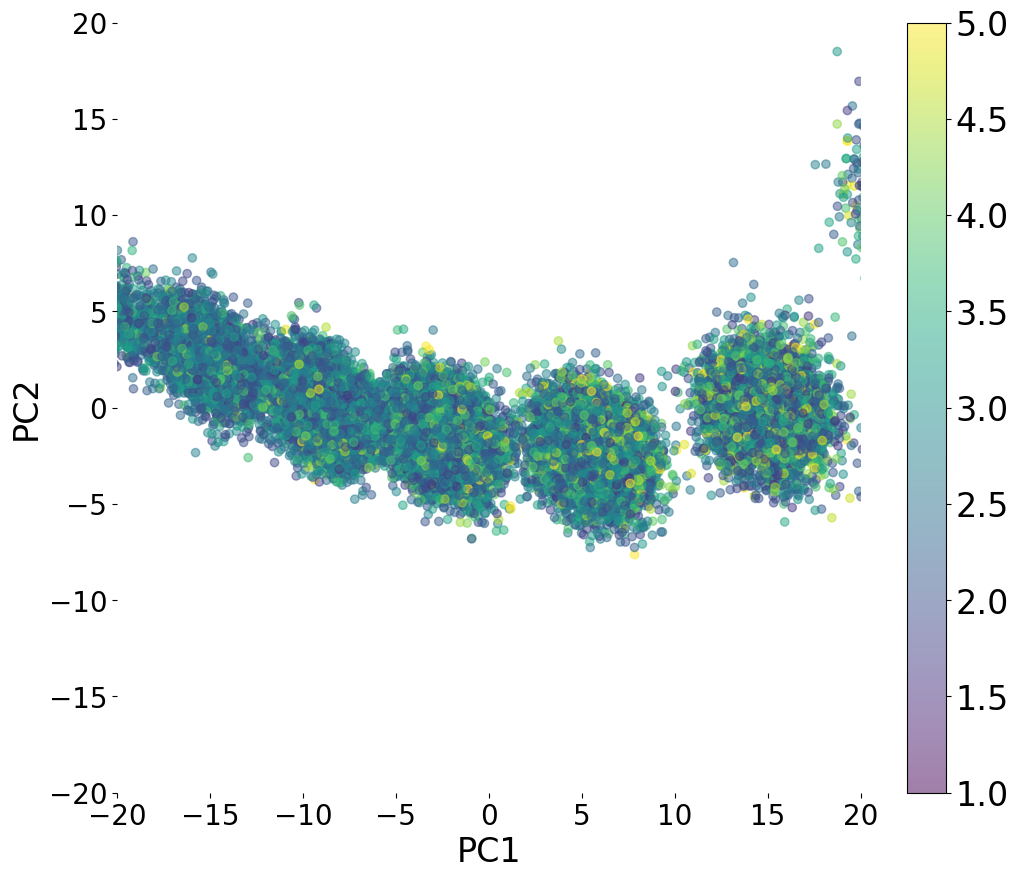

In [170]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(dataset.data.loc[data_sample_index_correct, 'SAS']),
            vmin = 1, vmax = 5)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
#plt.title('SAS True PCA Plot')
#plt.savefig(file_dir + 'True_SAS_PCA_Plot_training_set.png')
plt.show()

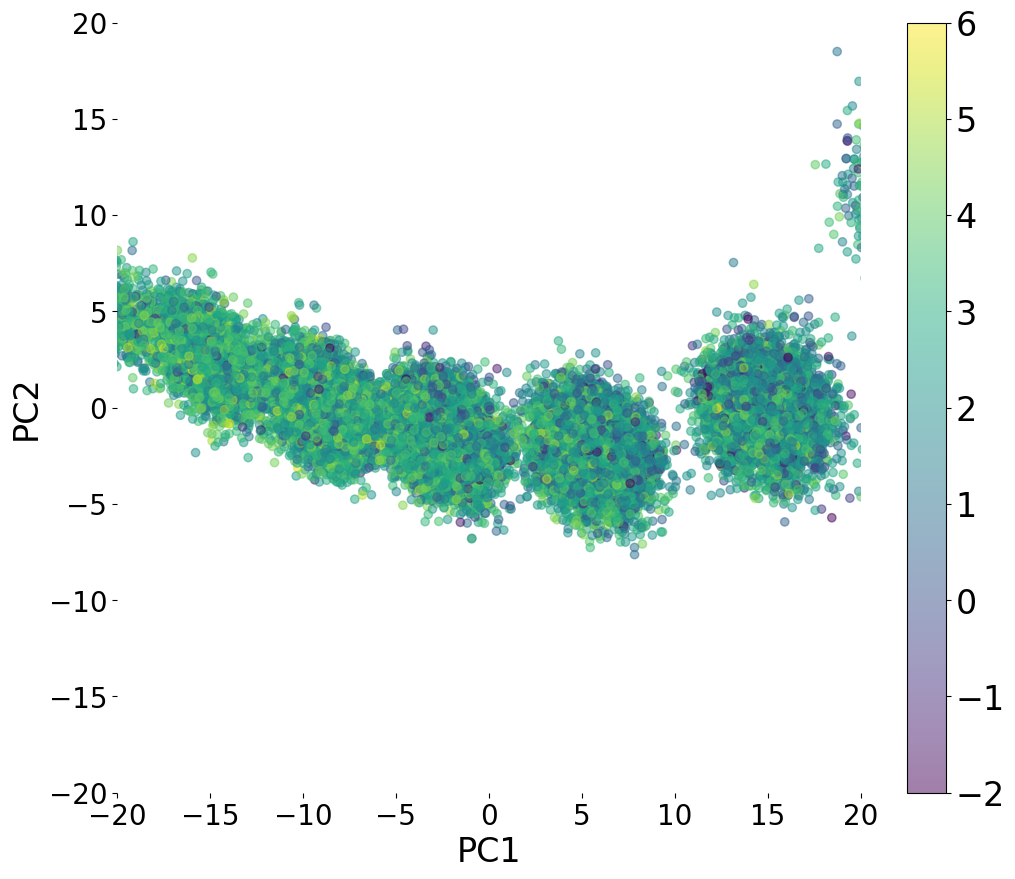

In [171]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(dataset.data.loc[data_sample_index_correct, 'logP']),
            vmin = -2, vmax = 6)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
#plt.title('LogP True PCA Plot')
#plt.savefig(file_dir + 'True_logp_PCA_Plot_training_set.png')
plt.show()

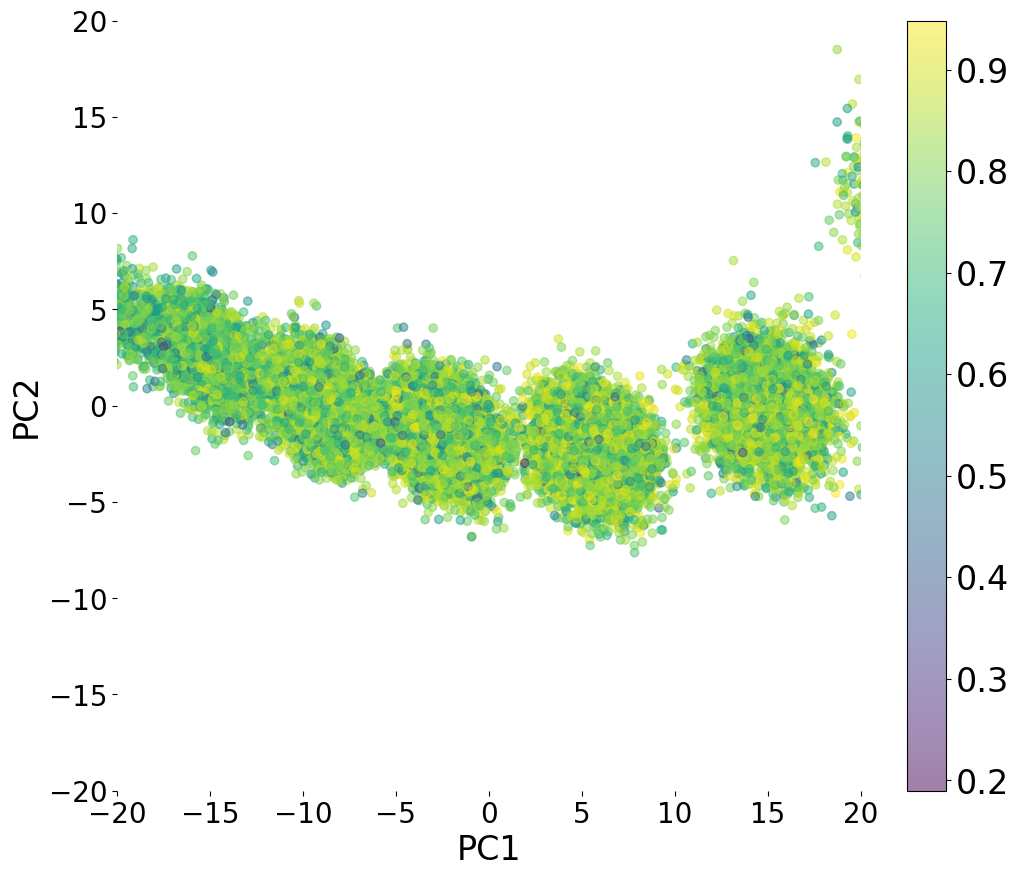

In [172]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(dataset.data.loc[data_sample_index_correct, 'qed']))
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
#plt.title('QED True PCA Plot')
#plt.savefig(file_dir + 'True_QED_PCA_Plot_training_set.png')
plt.show()

# Sample valid molecules and plots of the latent space

In [173]:
def update(save_to, sample, running_seqs, step):
    # select only still running
    running_latest = save_to[running_seqs]
    # update token at step position
    running_latest[:, step] = sample.data
    # save back
    save_to[running_seqs] = running_latest

    return save_to
def row_filter(row):
    return (row == vocab.EOS).any()

In [174]:
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles
# Fragment reconstruction
def replace_last(s, old, new):
    s_reversed = s[::-1]
    old_reversed = old[::-1]
    new_reversed = new[::-1]

    # Replace the first occurrence in the reversed string
    s_reversed = s_reversed.replace(old_reversed, new_reversed, 1)

    # Reverse the string back to original order
    return s_reversed[::-1]

def reconstruct(fragments):
    #print("Reconstructing...")
    frag_recomb_list = []
    frag_2_re = fragments[-1]
    for i in range(len(fragments)-1):
        frag_1_re = fragments[-1*i-2]
        recomb = replace_last(frag_2_re, "*", frag_1_re.replace("*", "",1))
        recomb_canon = MolToSmiles(MolFromSmiles(Chem.CanonSmiles(recomb)),rootedAtAtom = 1)
        #print("Base Molecule: ",frag_2_re)
        #print("Fragment: ",frag_1_re)
        #print("Recombined: ",recomb_canon)
        frag_recomb_list.append(recomb_canon)
        frag_2_re = recomb_canon
    #print("Reconstructed Fragments: ",frag_recomb_list)
    #print("Final Recombined Molecule", Chem.CanonSmiles(recomb))
    #molecules = [Chem.MolFromSmiles(smiles) for smiles in frag_recomb_list]
    #img = Chem.Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(600, 600))
    return MolFromSmiles(Chem.CanonSmiles(recomb))

In [205]:
sample_size = 2000
sample_std = 0.8
# Sampling from the prior
mu_sampled_stack = []
mu_enc_stack = []
sigma_enc_stack = []
z_sampled_stack = []
z_enc_stack = []
logp_sampled_true = []
logp_sampled_pred = []
logp_sampled_pred_enc = []
qed_sampled_true = []
sas_sampled_true = []
sas_sampled_pred = []
sas_sampled_pred_enc = []
mol_list = []
frag_list = []
max_length = config.get('max_length')
#max_length = 15
temperature = config.get('temperature')
temperature = 0.01
batch_size = 1
counter = 0
print(temperature)

0.01


In [206]:
model

Frag2Mol(
  (embedder): Embedding(646, 100)
  (latent2rnn): Linear(in_features=512, out_features=512, bias=True)
  (encoder): Encoder(
    (rnn): GRU(100, 512, num_layers=5, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=512, out_features=512, bias=True)
    (rnn2logv): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(100, 512, num_layers=5, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=512, out_features=646, bias=True)
  )
  (latent2hidden): LatentToHidden(
    (latent2hidden): Linear(in_features=512, out_features=2560, bias=True)
  )
)

In [207]:
with torch.no_grad():
    while len(mol_list)<sample_size:
        model_vae = model.cpu()
        model_vae.eval()
        samples, sampled = [], 0
        z = torch.normal(0, sample_std, size=(batch_size, model_vae.latent_size)).cpu()
        #z = z_stack[counter*batch_size:(counter+1)*batch_size]
        state = model_vae.latent2hidden(z)
        #state = model_vae.latent2rnn(z)
        #state = state.view(model_vae.hidden_layers, batch_size, model_vae.hidden_size)
        # all idx of batch
        sequence_idx = torch.arange(0, batch_size).long()

        # all idx of batch which are still generating
        running = torch.arange(0, batch_size).long()
        sequence_mask = torch.ones(batch_size, dtype=torch.bool)

        # idx of still generating sequences
        # with respect to current loop
        running_seqs = torch.arange(0, 1).long()
        lengths = [1] * batch_size

        generated = torch.Tensor(batch_size, max_length).long()
        generated.fill_(vocab.PAD)

        inputs = Variable(torch.Tensor(batch_size).long())
        inputs.fill_(vocab.SOS).long()
        step = 0
        while(step < max_length and len(running_seqs) > 0):
            inputs = inputs.unsqueeze(1)
            emb = model_vae.embedder(inputs)
            scores, state = model_vae.decoder(emb.cpu(), state.cpu(), lengths)
            scores = scores.squeeze(1)

            probs = F.softmax(scores / temperature, dim=1)
            inputs = torch.argmax(probs, 1).reshape(1, -1)
            
            # save next input
            generated = update(generated, inputs, running, step)
            # update global running sequence
            sequence_mask[running] = (inputs != vocab.EOS)
            running = sequence_idx.masked_select(sequence_mask)

            # update local running sequences
            running_mask = (inputs != vocab.EOS)
            running_seqs = ~running_seqs.masked_select(running_mask)

            # prune input and hidden state according to local update
            run_length = len(running_seqs)
            if run_length > 0:
                inputs = inputs.squeeze(0)
                inputs = inputs[running_seqs]
                state = state[:, running_seqs]
                running_seqs = torch.arange(0, run_length).long()

            lengths = [1] * run_length
            step += 1
        new_samples_torch = generated
        new_samples = generated.numpy()
        #print(new_samples)
        mask = np.apply_along_axis(row_filter, 1, new_samples)
        #save molecule

        for i in range(len(new_samples)):
            try:
                frags = vocab.translate(new_samples[i])
                mol = reconstruct(frags)
                '''
                frags = mols_from_smiles(vocab.translate(new_samples[i]))
                mol = join_molecules(frags[0], frags[1])
                for j, frag in enumerate(frags[2:]):
                    #print(i, mol_to_smiles(frag), mol_to_smiles(mol))
                    mol = join_molecules(mol, frag)
                    #print(i, mol_to_smiles(mol))
                    mol = mols_from_smiles(mols_to_smiles([mol]))[0]
                '''
                logp_sample = Crippen.MolLogP(mol)
                qed_sample = QED.qed(mol)
                sas_sample = calculateScore(mol)
                mol_list.append(mol)
                '''
                model = model.cuda()
                
                # predict and store properties and vectors from the sampled z
                frag_list.append(vocab.translate(new_samples[i]))
                pred_logp, pred_sas = model.mlp(z.cuda())
                logp_sampled_pred.append(pred_logp.item())
                sas_sampled_pred.append(pred_sas.item())
                
                # predict and store the properties and vectors of the recombined molecules sampled from z
                vec_frag_sum = torch.sum(model.embedder(torch.tensor(new_samples[i]).cuda()[torch.tensor(new_samples[i]).cuda() > 2]), 0)
                z_enc, mu_enc, sigma_enc = model.encoder(vec_frag_sum)
                pred_logp_enc, pred_sas_enc = model.mlp(mu_enc.cuda())
                if len(mu_enc_stack) == 0:
                    mu_enc_stack = mu_enc[None, :]
                    sigma_enc_stack = sigma_enc[None, :]
                else:
                    mu_enc_stack = torch.cat((mu_enc_stack, mu_enc[None, :]),0)
                    sigma_enc_stack = torch.cat((sigma_enc_stack, sigma_enc[None, :]),0)
                logp_sampled_pred_enc.append(pred_logp_enc.item())
                sas_sampled_pred_enc.append(pred_sas_enc.item())
                
                # store the true properties of the recombined molecules sampled from z
                '''
                logp_sampled_true.append(logp_sample)
                sas_sampled_true.append(sas_sample)
                qed_sampled_true.append(qed_sample)
                if len(z_sampled_stack) == 0:
                    z_sampled_stack = z
                else:
                    z_sampled_stack = torch.cat((z_sampled_stack, z),0)
            except:
                continue
        counter += 1
        if counter % 500 ==0:
            print("iteration: ", counter)
            print(len(mol_list))
            print("Unique Molecules: ", len(set(mols_to_smiles(mol_list))))
            #break
        if counter % 2000 == 0:
            clear_output(wait=True)

iteration:  2500
1907
Unique Molecules:  588


In [151]:
mols_to_smiles(mol_list)

['*CC(=O)NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+][NH2+][NH2+][NH2+]CC',
 '*CC(=O)NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)NCC',
 '*NNCC=C',
 '*CC(=O)NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+]OCC',
 '*NC(=O)C(=O)C(=O)C(=O)[NH2+][NH2+][NH2+][NH2+][NH2+][NH2+][NH2+][NH2+]CC',
 '*CC(=O)NNNNCCC',
 '*N[NH2+]*',
 '*NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+]OCC',
 '*CC(=O)NNNC(=O)C(=O)C(=O)C(=O)N[NH2+]OC',
 '*CC(=O)NNCC',
 '*CC(=O)NNNNNOC',
 '*NNC(=O)C(=O)N[NH2+]CC',
 '*NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+][NH2+]OCC',
 '*CC(=O)NNC(=O)C(=O)C(=O)C(=O)OCC',
 'CCCC(=O)NNC(=O)C(=O)C(=O)C(=O)[NH2+][NH2+][NH2+][NH2+][NH2+][NH2+]OCC',
 '*NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)NNCCC',
 '*NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)NN[NH2+]*',
 '*NNC(=O)C(=O)C(=O)C(=O)NCC',
 '*NC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+][NH2+][NH2+][NH2+][NH2+]OCC',
 '*CC(=O)NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+]OCC',
 '*NNN*',
 '*CC(=O)NNC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+][NH2+][NH2

In [59]:
#Save Sampled Molecules
torch.save(z_sampled_stack.detach(), file_dir + 'z_sampled_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
torch.save(mu_enc_stack.detach(), file_dir + 'mu_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
torch.save(sigma_enc_stack.detach(), file_dir + 'sigma_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
logp_sampled_true_pd = pd.DataFrame(logp_sampled_true)
logp_sampled_true_pd.to_csv(file_dir + 'logp_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
logp_sampled_pred_pd = pd.DataFrame(logp_sampled_pred)
logp_sampled_pred_pd.to_csv(file_dir + 'logp_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
logp_sampled_pred_enc_pd = pd.DataFrame(logp_sampled_pred_enc)
logp_sampled_pred_enc_pd.to_csv(file_dir + 'logp_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_true_pd = pd.DataFrame(sas_sampled_true)
sas_sampled_true_pd.to_csv(file_dir + 'sas_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_pred_pd = pd.DataFrame(sas_sampled_pred)
sas_sampled_pred_pd.to_csv(file_dir + 'sas_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_pred_enc_pd = pd.DataFrame(sas_sampled_pred_enc)
sas_sampled_pred_enc_pd.to_csv(file_dir + 'sas_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
qed_sampled_true_pd = pd.DataFrame(qed_sampled_true)
qed_sampled_true_pd.to_csv(file_dir + 'qed_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
mol_list_pd = pd.DataFrame(mols_to_smiles(mol_list))
mol_list_pd.to_csv(file_dir + 'mol_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
frag_list_pd = pd.DataFrame(frag_list)
frag_list_pd.to_csv(file_dir + 'frag_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)

In [20]:
# run this cell if we already have the files
z_sampled_stack = torch.load(file_dir + 'z_sampled_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
mu_enc_stack = torch.load(file_dir + 'mu_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
sigma_enc_stack = torch.load(file_dir + 'sigma_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
logp_sampled_true = list(pd.read_csv(file_dir + 'logp_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
logp_sampled_pred = list(pd.read_csv(file_dir + 'logp_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
logp_sampled_pred_enc = list(pd.read_csv(file_dir + 'logp_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_true = list(pd.read_csv(file_dir + 'sas_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_pred = list(pd.read_csv(file_dir + 'sas_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_pred_enc = list(pd.read_csv(file_dir + 'sas_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
qed_sampled_true = list(pd.read_csv(file_dir + 'qed_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
mol_list = list(pd.read_csv(file_dir + 'mol_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
frag_list = pd.read_csv(file_dir + 'frag_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')

In [208]:
unique_molecules = list(set(mols_to_smiles(mol_list)))
unique_molecules

['*CC(=O)NCCNC(=O)CNC(=O)C(=O)N(*)[NH2+]OC',
 '*CC(=O)NCCNC(=O)CNC(=O)C(=O)C(=O)C(=O)[NH2+][NH2+]c1ccc(*)nc1',
 '*C1=C(N)C2CCC3(*)CC4CCC2(*)CC2CCC4(*)CC4CCC2(*)CC2CCC4(*)CC4CCC2(*)CC2CCC4(*)CC4CCC2(*)CCC4(*)CCC(*)C3=NC=N1',
 '*[NH2+]C(=O)C(=O)C1(*)CCC2CCC3(*)CCC2CC2(*)CCC3CC3(*)CCC2CC2(*)CCC3CC3(*)CCCC(CC(*)(*)CCCC31)C(=O)C2=O',
 '*C(=O)C(=O)C1(*)CCC2C(*)CCC3(*)CCC4(*)CCC3CC3(*)CCC4CC4(*)CCC3CC3(*)CCC4CC24CCC3CCC2(*)CCC4C(*)=CC(*)=CC=C1N2',
 '*CC(=O)NCCNC(=O)CC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+]CCC',
 '*CC(=O)NCCNC(=O)CNC(=O)C(=O)N[NH2+]N*',
 '*CC(=O)NN(*)[NH2+]OC',
 '*CC(=O)NCCNC(=O)CC(=O)C(=O)C(=O)NC1CCC2(*)CCC(*)(*)CCCC12',
 '*CCNC(=O)CC(=O)C(=O)C(=O)C(=O)C1CCC2(*)CCC3(*)CCC2CC2(*)CCC3CC3(*)CCC2CC(*)(*)CCCC1[NH2+]C3=O',
 'CCCC(=O)CC(=O)NCCNC(=O)CC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)[NH2+]CC',
 '*CC(=O)NC(*)NC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)NC1CCCC2(*)CCC(*)(*)CCCC12',
 '*CC(=O)NCCNC(=O)CC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C1CCCC2(*)CCC3(*)CCCC2CC2(*)CCC3CC(*)(*)CCC12',
 '*C

In [209]:
mol_list_rand = random.sample(unique_molecules, 64)
mol_list_rand

['*CC(=O)NCCNC(=O)CNN(*)OCC',
 '*CCNC(=O)CC(=O)C(=O)C(=O)C(=O)C1CCC2(*)CCC3(*)CCC2CC2(*)CCC3CC3(*)CCC2CC2(*)CCCC3CC3(*)CCCC2CC(*)(*)CCCC13',
 '*CCNC(=O)CC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C1CCCC2(*)CCC(*)(C(=O)C(*)=O)CCC12',
 '*CC(=O)NCCNC(=O)CC(=O)C(=O)C(=O)C(=O)NC(=O)C(=O)C(=O)C(=O)C(=O)C(*)=O',
 '*CC(=O)NCCNC(=O)CNC(=O)C(=O)N[NH2+]C1CCCC(*)(NC(*)*)C1',
 '*[NH2+]C(=O)C(=O)C12CCC3CC(*)(C(=O)C(*)=O)CCC1C(*)CCC1(*)CCC4(*)CCC1CC1(*)CCC4CC34CCC(CC(*)(*)CCC14)C2',
 '*CC(=O)NCCNC(=O)CC(=O)C(=O)C1CCC2(*)CCC3(*)CCC2CC2(*)CCC3CC3(*)CCC2CC2(*)CCC3CC3(*)CCCC2CC(*)(*)CCCC13',
 '*CC(=O)NCCNC(=O)CC(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)C(=O)N(*)[NH2+]CC',
 '*CCNC(=O)CC(=O)C(=O)C(=O)C(=O)C1CCC2(*)CCC3(*)CCC2CC2(*)CCC3CC3(*)CCC2CC(*)(*)CCCC1[NH2+]C3=O',
 '*NC(=O)C(=O)C(=O)C(=O)C1CCC2(*)CCC3(*)CCC2CC2(*)CCC3CC3(*)CCCC(CC(*)(*)CCCC13)[NH2+]C(=O)C2=O',
 '*[NH2+]C12CCC3CC(*)(C(=O)C(=O)C(=O)C(*)=O)CCC1C(C(=O)C(*)=O)CCC1(*)CCC34CCC(CC(*)(C(=O)C(*)=O)CCCC14)C2',
 '*NC(=O)C(=O)C(=O)C

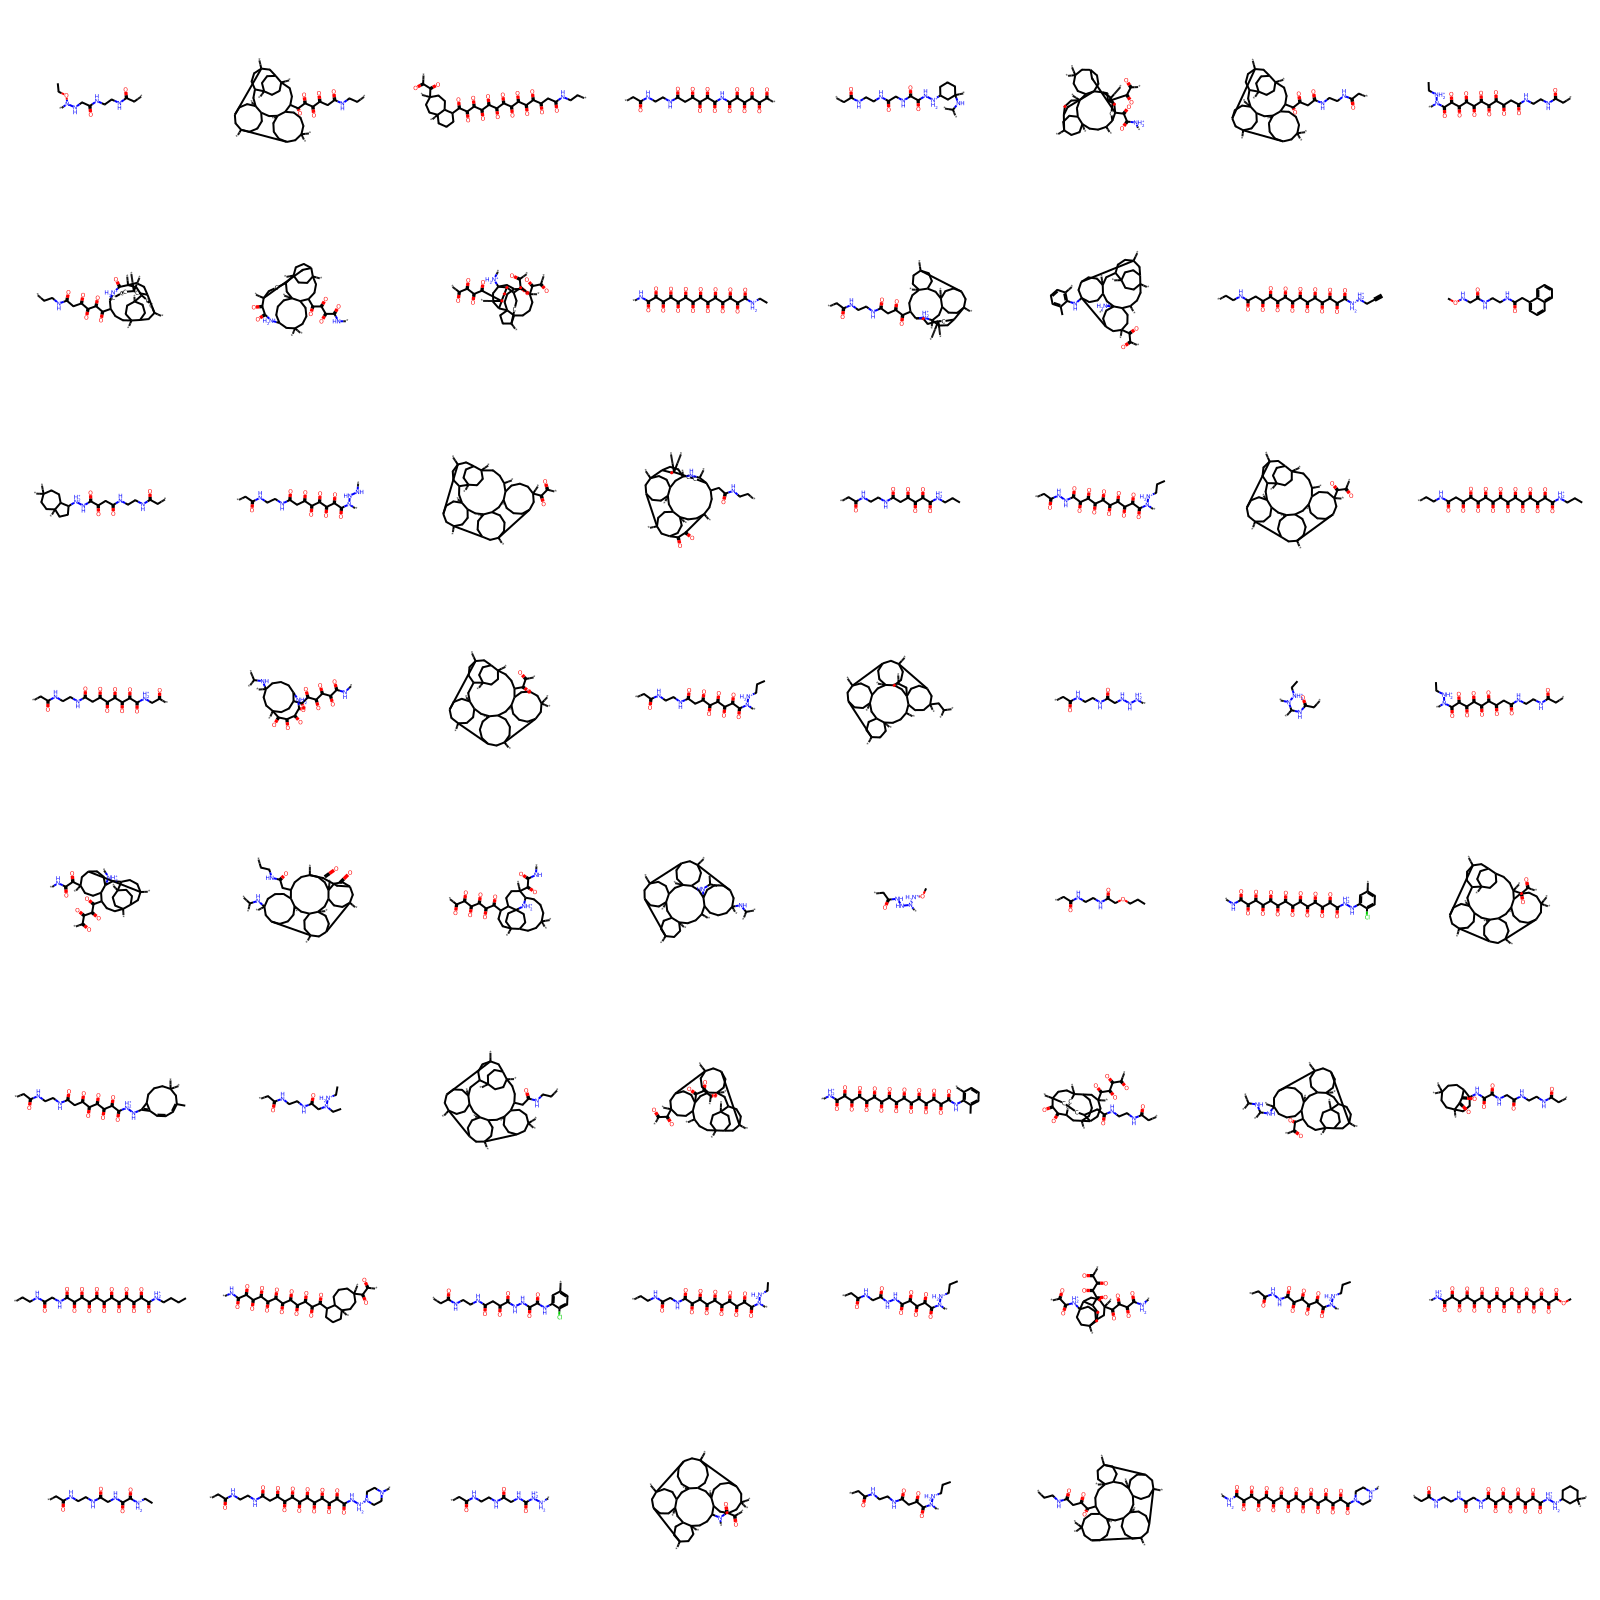

In [210]:
Draw.MolsToGridImage(mols_from_smiles(mol_list_rand), molsPerRow=8, maxMols=999999)

# Plot Sampled Latent Space

In [89]:
x = z_sampled_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

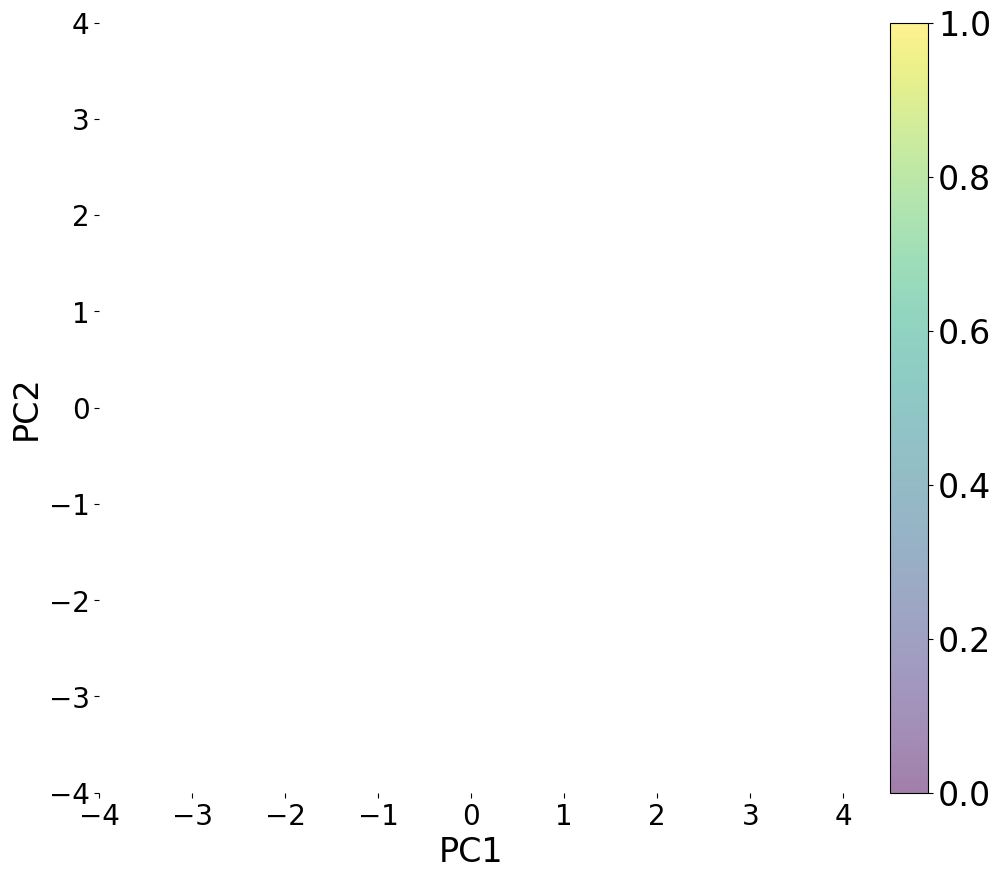

In [90]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_pred))
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
#plt.title('Predicted SAS PCA Plot')
#plt.savefig(file_dir + 'Predicted_SAS_PCA_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

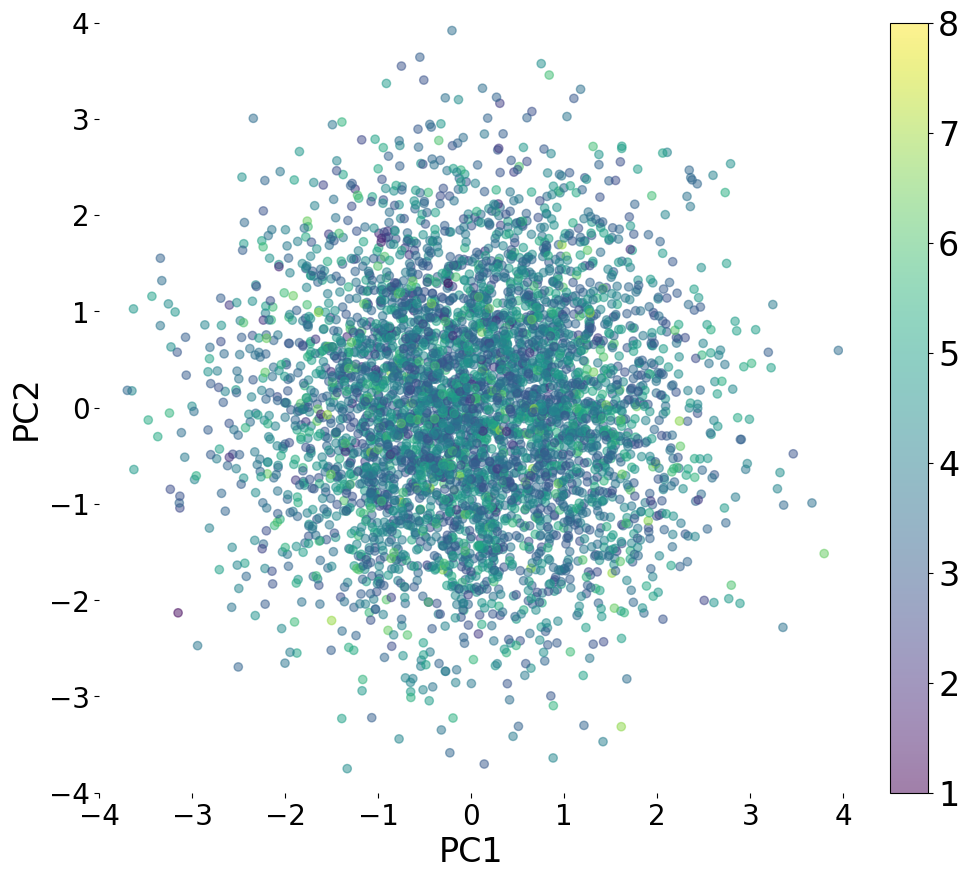

In [92]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_true),
            vmin = 1, vmax = 8)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
#plt.title('True SAS PCA Plot')
#plt.savefig(file_dir + 'True_SAS_PCA_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

C:\Users\panuk\AppData\Local\Temp\ipykernel_20724\2780668593.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(principalDf['pc1'].to_numpy(),


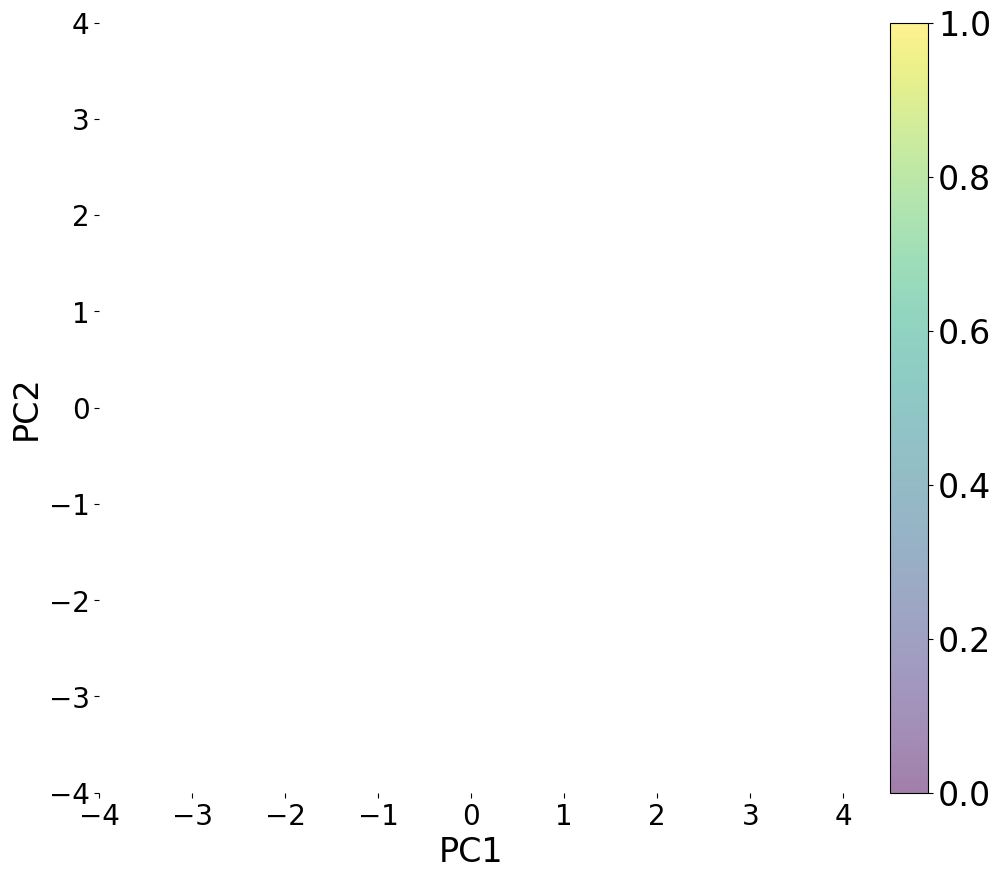

In [93]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(logp_sampled_pred),
            vmin = -2, vmax = 10)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
#plt.title('Predicted logp PCA Plot')
#plt.savefig(file_dir + 'Predicted_logp_PCA_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

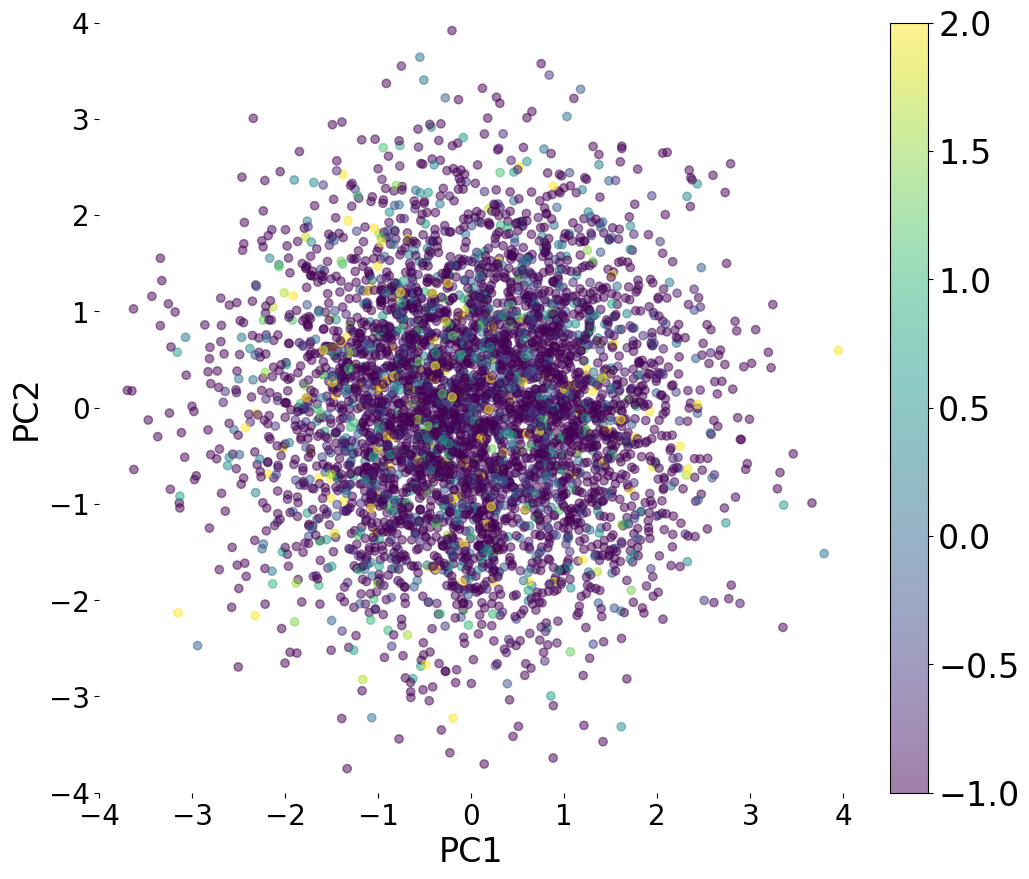

In [94]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(logp_sampled_true),
            vmin = -1, vmax = 2)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
#plt.title('True logp PCA Plot')
#plt.savefig(file_dir + 'True_logp_PCA_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

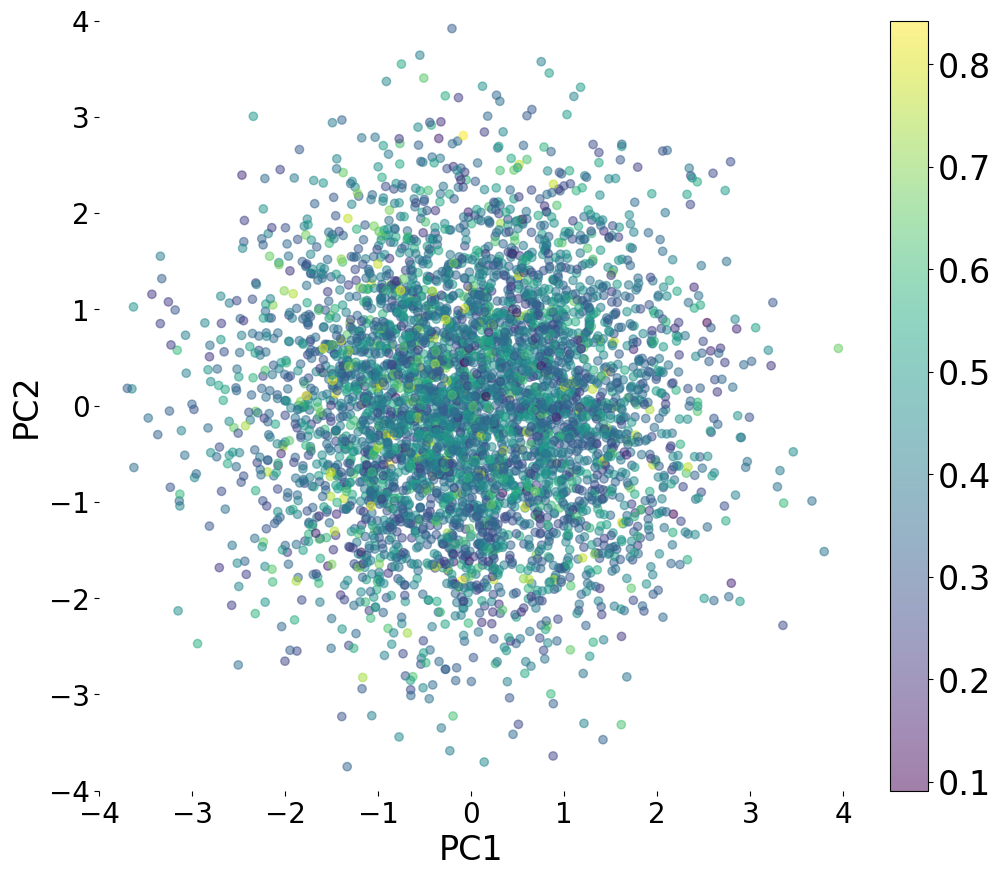

In [95]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(qed_sampled_true))
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
#plt.title('True QED PCA Plot')
#plt.savefig(file_dir + 'True_QED_PCA_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

In [19]:
x_enc = mu_enc_stack.cpu().detach().numpy()
x_enc = StandardScaler().fit_transform(x_enc)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_enc)
principalDf_enc = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

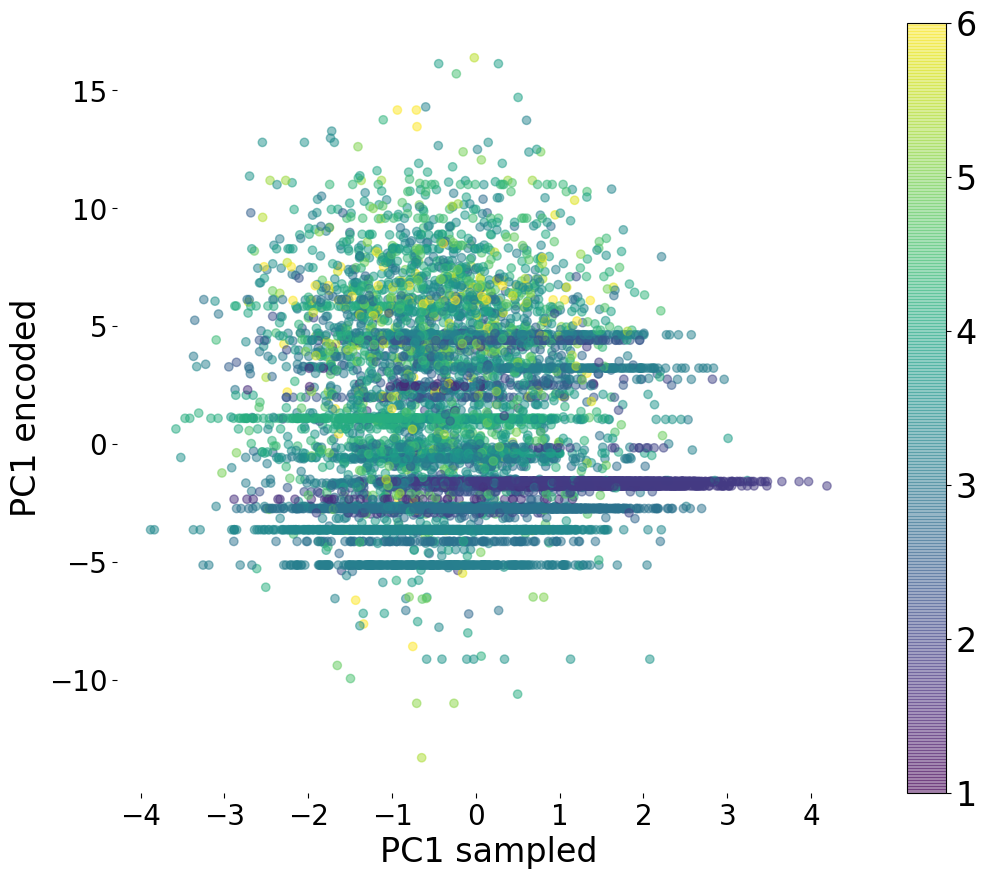

In [20]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf_enc['pc1'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_true),
            vmin = 1, vmax = 6)
plt.xlabel("PC1 sampled", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC1 encoded", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('True SAS PCA Plot')
plt.savefig(file_dir + 'True_SAS_PCA_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '_sampled_encoded.png')
plt.show()

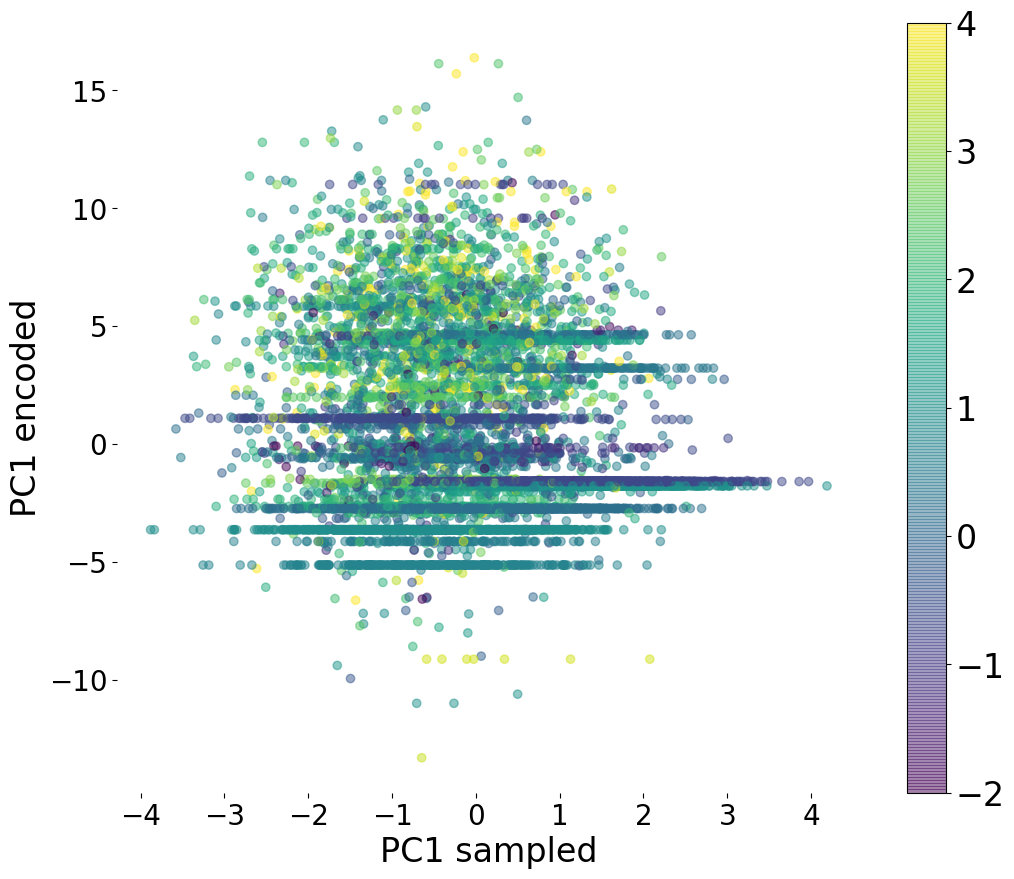

In [21]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf_enc['pc1'].to_numpy(),  
            alpha=0.5, 
            c=np.array(logp_sampled_true),
            vmin = -2, vmax = 4)
plt.xlabel("PC1 sampled", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC1 encoded", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('True logp PCA Plot')
plt.savefig(file_dir + 'True_logp_PCA_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '_sampled_encoded.png')
plt.show()

In [80]:
data_box = pd.DataFrame(list(zip(sas_sampled_pred, sas_sampled_true, logp_sampled_pred, logp_sampled_true, qed_sampled_true)), columns=['Predicted SAS','True SAS', 'Predicted LogP', 'True LogP', 'True QED'])
data_box

Predicted SAS  True SAS  Predicted LogP  True LogP  True QED
0          6.720998  2.865797       -2.200543     1.4441  0.725843
1          6.164308  1.877340        3.942850    -0.6891  0.538215
2          5.447052  4.126337        1.405711    -0.6444  0.492971
3          3.599534  2.359029       -0.732075     2.4951  0.793200
4          6.960550  4.126337       18.478912    -0.6444  0.492971
...             ...       ...             ...        ...       ...
9995       7.952086  2.900245        4.618074     0.1853  0.549818
9996       5.276816  4.126337        7.841175    -0.6444  0.492971
9997       7.020675  2.888274       10.495290     0.5738  0.584226
9998       9.040832  2.040421       10.689970     1.9793  0.774394
9999       5.891997  3.210763       11.630422     0.2546  0.672902

[10000 rows x 5 columns]

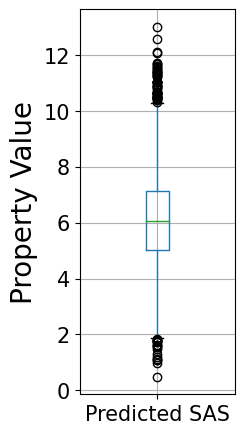

In [79]:
fig, ax1 = plt.subplots(figsize=(2, 5))
data_box.boxplot(column=['Predicted SAS'])
plt.yticks(fontsize=15)
plt.ylabel('Property Value', fontsize = 20)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'Predicted_SAS_Box_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

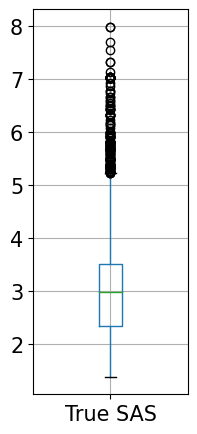

In [69]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['True SAS'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'True_SAS_Box_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

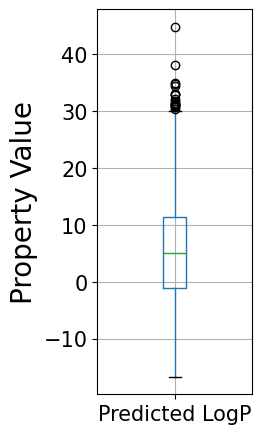

In [81]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['Predicted LogP'])
plt.yticks(fontsize=15)
plt.ylabel('Property Value', fontsize = 20)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'Predicted_LogP_Box_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

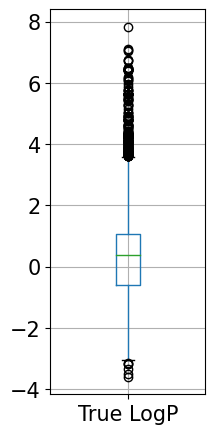

In [71]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['True LogP'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'True_LogP_Box_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

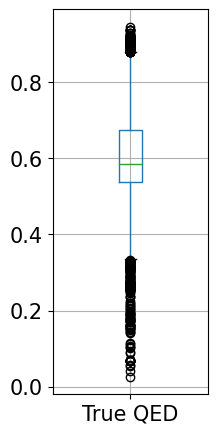

In [82]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['True QED'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'True_QED_Box_Plot_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

# Sample from prior keeping all points

In [51]:
def update(save_to, sample, running_seqs, step):
    # select only still running
    running_latest = save_to[running_seqs]
    # update token at step position
    running_latest[:, step] = sample.data
    # save back
    save_to[running_seqs] = running_latest

    return save_to
def row_filter(row):
    return (row == vocab.EOS).any()

In [52]:
sample_size = 10000
sample_var = 1

In [109]:
# Sampling from the prior
z_sampled_stack_all = []
logp_sampled_pred_all = []
sas_sampled_pred_all = []
max_length = config.get('max_length')
temperature = config.get('temperature')
batch_size = 1
counter = 0
with torch.no_grad():
    while len(z_sampled_stack_all)<sample_size:
        model_vae = model.cpu()
        model_vae.eval()
        z = torch.normal(0, sample_var, size=(1, batch_size, 100))
        model = model.cuda()
        pred_logp, pred_sas = model.mlp(z.cuda())
        logp_sampled_pred_all.append(pred_logp.item())
        sas_sampled_pred_all.append(pred_sas.item())
        if len(z_sampled_stack_all) == 0:
            #mu_sampled_stack = mu[None, :]
            z_sampled_stack_all = z[0][0][None, :]
        else:
            #mu_sampled_stack = torch.cat((mu_sampled_stack, mu[None, :]),0)
            z_sampled_stack_all = torch.cat((z_sampled_stack_all, z[0][0][None, :]),0)
        counter += 1
        #break
        if counter % 500 ==0:
            print(len(z_sampled_stack_all))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [110]:
#Save Sampled Molecules
torch.save(z_sampled_stack_all.detach(), file_dir + 'z_sampled_stack_tensor_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.pt')
logp_sampled_pred_all_pd = pd.DataFrame(logp_sampled_pred_all)
logp_sampled_pred_all_pd.to_csv(file_dir + 'logp_sampled_pred_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_pred_all_pd = pd.DataFrame(sas_sampled_pred_all)
sas_sampled_pred_all_pd.to_csv(file_dir + 'sas_sampled_pred_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.csv', index=False)

In [111]:
z_sampled_stack_all = torch.load(file_dir + 'z_sampled_stack_tensor_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.pt')
logp_sampled_pred_all = list(pd.read_csv(file_dir + 'logp_sampled_pred_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_pred_all = list(pd.read_csv(file_dir + 'sas_sampled_pred_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.csv')['0'])

In [112]:
x = z_sampled_stack_all.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

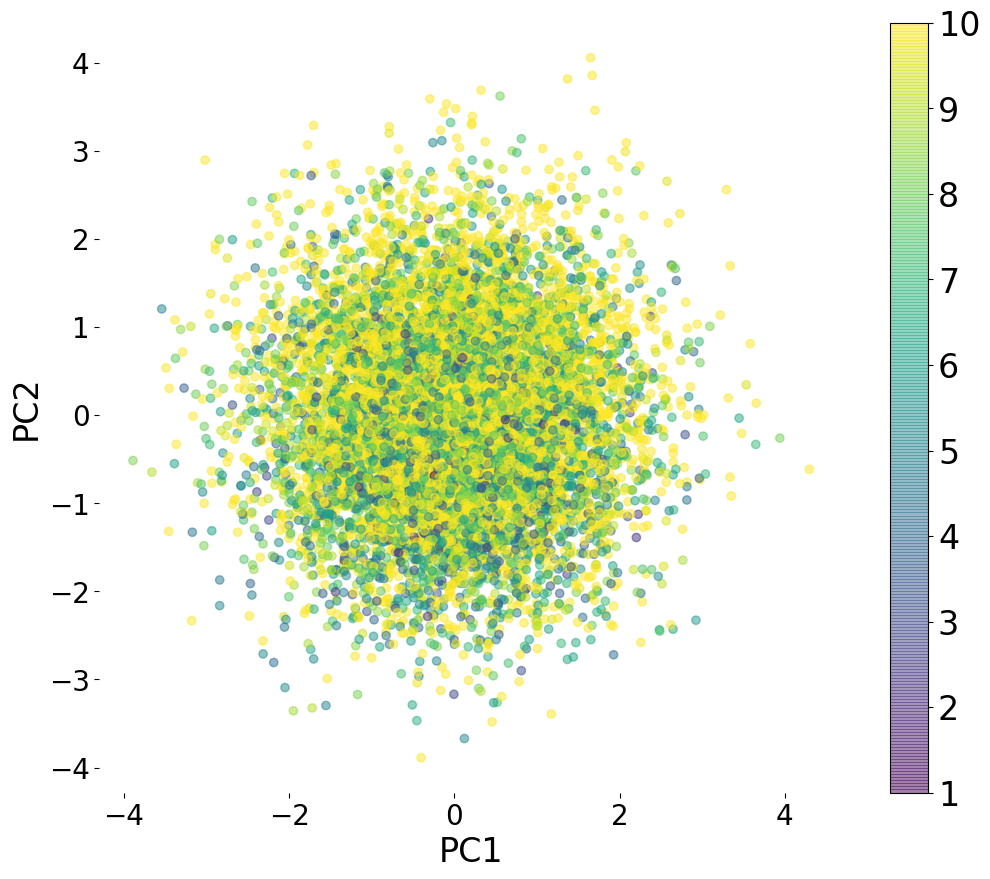

In [117]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_pred_all),
            vmin = 1, vmax = 10)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('Predicted SAS PCA Plot')
plt.savefig(file_dir + 'Predicted_SAS_PCA_Plot_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

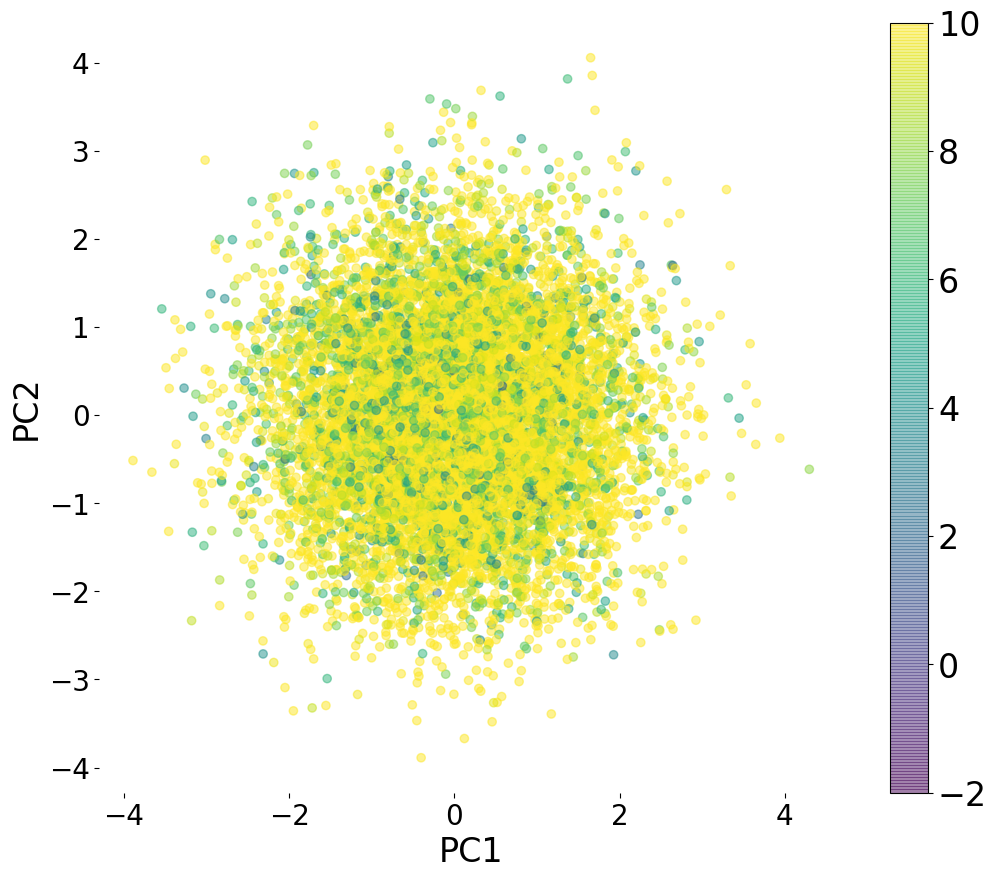

In [118]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(logp_sampled_pred_all),
            vmin = -2, vmax = 10)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('Predicted logp PCA Plot')
plt.savefig(file_dir + 'Predicted_logp_PCA_Plot_all_n_0_' + str(sample_var) + '_' + str(sample_size) + '.png')
plt.show()

# Moving in the latent space

In [97]:
def sample_molecule(z_test):
    state = model.latent2rnn(z_test)
    state = state.view(model.hidden_layers, 1, model.hidden_size)
    # all idx of batch
    sequence_idx = torch.arange(0, 1).long()

    # all idx of batch which are still generating
    running = torch.arange(0, 1).long()
    sequence_mask = torch.ones(1, dtype=torch.bool)

    # idx of still generating sequences
    # with respect to current loop
    running_seqs = torch.arange(0, 1).long()
    lengths = [1] * 1

    generated = torch.Tensor(1, max_length).long()
    generated.fill_(vocab.PAD)

    inputs = Variable(torch.Tensor(1).long())
    inputs.fill_(vocab.SOS).long()
    step = 0
    while(step < max_length and len(running_seqs) > 0):
        inputs = inputs.unsqueeze(1)
        emb = model.embedder(inputs)
        scores, state = model.decoder(emb, state, lengths)
        scores = scores.squeeze(1)

        probs = F.softmax(scores / temperature, dim=1)
        inputs = torch.argmax(probs, 1).reshape(1, -1)

        # save next input
        generated = update(generated, inputs, running, step)
        # update global running sequence
        sequence_mask[running] = (inputs != vocab.EOS)
        running = sequence_idx.masked_select(sequence_mask)

        # update local running sequences
        running_mask = (inputs != vocab.EOS)
        running_seqs = running_seqs.masked_select(running_mask)

        # prune input and hidden state according to local update
        run_length = len(running_seqs)
        if run_length > 0:
            inputs = inputs.squeeze(0)
            inputs = inputs[running_seqs]
            state = state[:, running_seqs]
            running_seqs = torch.arange(0, run_length).long()

        lengths = [1] * run_length
        step += 1
    new_samples = generated.numpy()
    #print(new_samples)
    mask = np.apply_along_axis(row_filter, 1, new_samples)
    return new_samples

def update(save_to, sample, running_seqs, step):
    # select only still running
    running_latest = save_to[running_seqs]
    # update token at step position
    running_latest[:, step] = sample.data
    # save back
    save_to[running_seqs] = running_latest

    return save_to
def row_filter(row):
    return (row == vocab.EOS).any()

In [76]:
mol_graph_list = mols_from_smiles(mol_list)

In [79]:
mol_list[9]

'CN(CNC(=O)c1csc(C2CC(O)C(CO)O2)n1)N1CCOCC1'

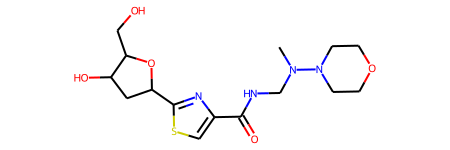

In [78]:
mol_graph_list[9]

In [277]:
z_linspace = torch.linspace(-6, 6, steps=13)
z_linspace

tensor([-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])

In [278]:
z_mol = z_sampled_stack[9]
z_mol

tensor([ 2.5316e-01,  1.6970e+00, -1.6346e-01,  6.8586e-01,  1.5705e+00,
        -1.0009e+00, -5.6543e-01,  1.5344e+00,  9.0020e-02,  6.2267e-01,
         1.2782e+00, -1.8211e+00, -4.3522e-01,  1.2824e+00,  1.3729e+00,
        -1.7786e+00, -7.9963e-01,  3.3617e+00,  4.1889e-01,  5.8509e-01,
        -9.7459e-01, -1.2961e+00,  4.4971e-01, -5.8847e-01, -4.3322e-01,
         4.6142e-01,  1.7843e-01,  5.8840e-02, -5.6244e-01, -6.2478e-01,
        -1.2585e+00, -4.0272e-01,  2.1271e-01, -4.7892e-01, -7.5943e-01,
         5.5571e-01,  2.3814e-01,  1.4382e+00,  4.3573e-02, -5.8625e-01,
        -1.8845e+00, -2.8034e-01,  2.6556e-01,  6.9070e-01,  1.4373e+00,
        -5.6574e-01, -2.6957e-01,  1.4281e+00, -1.2411e+00, -3.0326e-01,
        -5.7281e-01, -2.1182e-01, -3.4977e-01, -1.4411e-01,  2.7673e-01,
        -7.8496e-01, -1.4141e+00, -1.8705e-01, -1.5996e+00, -3.3204e-01,
        -1.6303e+00,  1.7476e+00,  1.2559e+00, -9.3644e-01,  1.5607e+00,
         5.9328e-01,  6.2345e-01,  8.0619e-01,  5.6

In [354]:
ind_1 = random.randint(0, len(z_mol) - 1)
print("Random Index 1:", ind_1)
ind_2 = random.randint(0, len(z_mol) - 1)
print("Random Index 2:", ind_2)

Random Index 1: 41
Random Index 2: 12


In [355]:
for idx, (z_step) in enumerate(z_linspace):
    for idx_2, (z_step_2) in enumerate(z_linspace):
        z_add = torch.zeros(len(z_mol))
        z_add_2 = torch.zeros(len(z_mol))
        z_add[ind_1] += z_step
        z_add_2[ind_2] += z_step_2
        z_search = z_mol + z_add + z_add_2
        if idx_2 == 0:
            z_stack_2 = z_search[None,:]
        else:
            z_stack_2 = torch.cat((z_stack_2,z_search[None,:]),0)
    
    if idx == 0:
        z_stack = z_stack_2[None,:]
    else:
        z_stack = torch.cat((z_stack, z_stack_2[None,:]), 0)

In [356]:
all(z_stack[5,5]==z_mol)

False

In [357]:
new_samples = sample_molecule(z_mol)
frags = mols_from_smiles(vocab.translate(new_samples[0]))
mol = join_molecules(frags[0], frags[1])
for i, frag in enumerate(frags[2:]):
    mol = join_molecules(mol, frag)

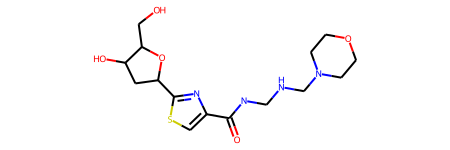

In [358]:
mol

In [359]:
mol_list = []
max_length = config.get('max_length')
temperature = config.get('temperature')
model = model.cpu()
counter = 0
for z_stack_row in z_stack:
    for z_stack_i in z_stack_row:
        print(counter)
        print(all(z_stack_i==z_mol))
        new_samples = sample_molecule(z_stack_i)
        frags = mols_from_smiles(vocab.translate(new_samples[0]))
        counter += 1
        try:
            mol = join_molecules(frags[0], frags[1])
            for i, frag in enumerate(frags[2:]):
                mol = join_molecules(mol, frag)
            mol_list.append(mol)
        except:
            mol_list.append(mol_list[-1])

0
False
1
False
2
False
3
False
4
False
5
False
6
False
7
False
8
False
9
False
10
False
11
False
12
False
13
False
14
False
15
False
16
False
17
False
18
False
19
False
20
False
21
False
22
False
23
False
24
False
25
False
26
False
27
False
28
False
29
False
30
False
31
False
32
False
33
False
34
False
35
False
36
False
37
False
38
False
39
False
40
False
41
False
42
False
43
False
44
False
45
False
46
False
47
False
48
False
49
False
50
False
51
False
52
False
53
False
54
False
55
False
56
False
57
False
58
False
59
False
60
False
61
False
62
False
63
False
64
False
65
False
66
False
67
False
68
False
69
False
70
False
71
False
72
False
73
False
74
False
75
False
76
False
77
False
78
False
79
False
80
False
81
False
82
False
83
False
84
True
85
False
86
False
87
False
88
False
89
False
90
False
91
False
92
False
93
False
94
False
95
False
96
False
97
False
98
False
99
False
100
False
101
False
102
False
103
False
104
False
105
False
106
False
107
False
108
False
109
False
110
False
1

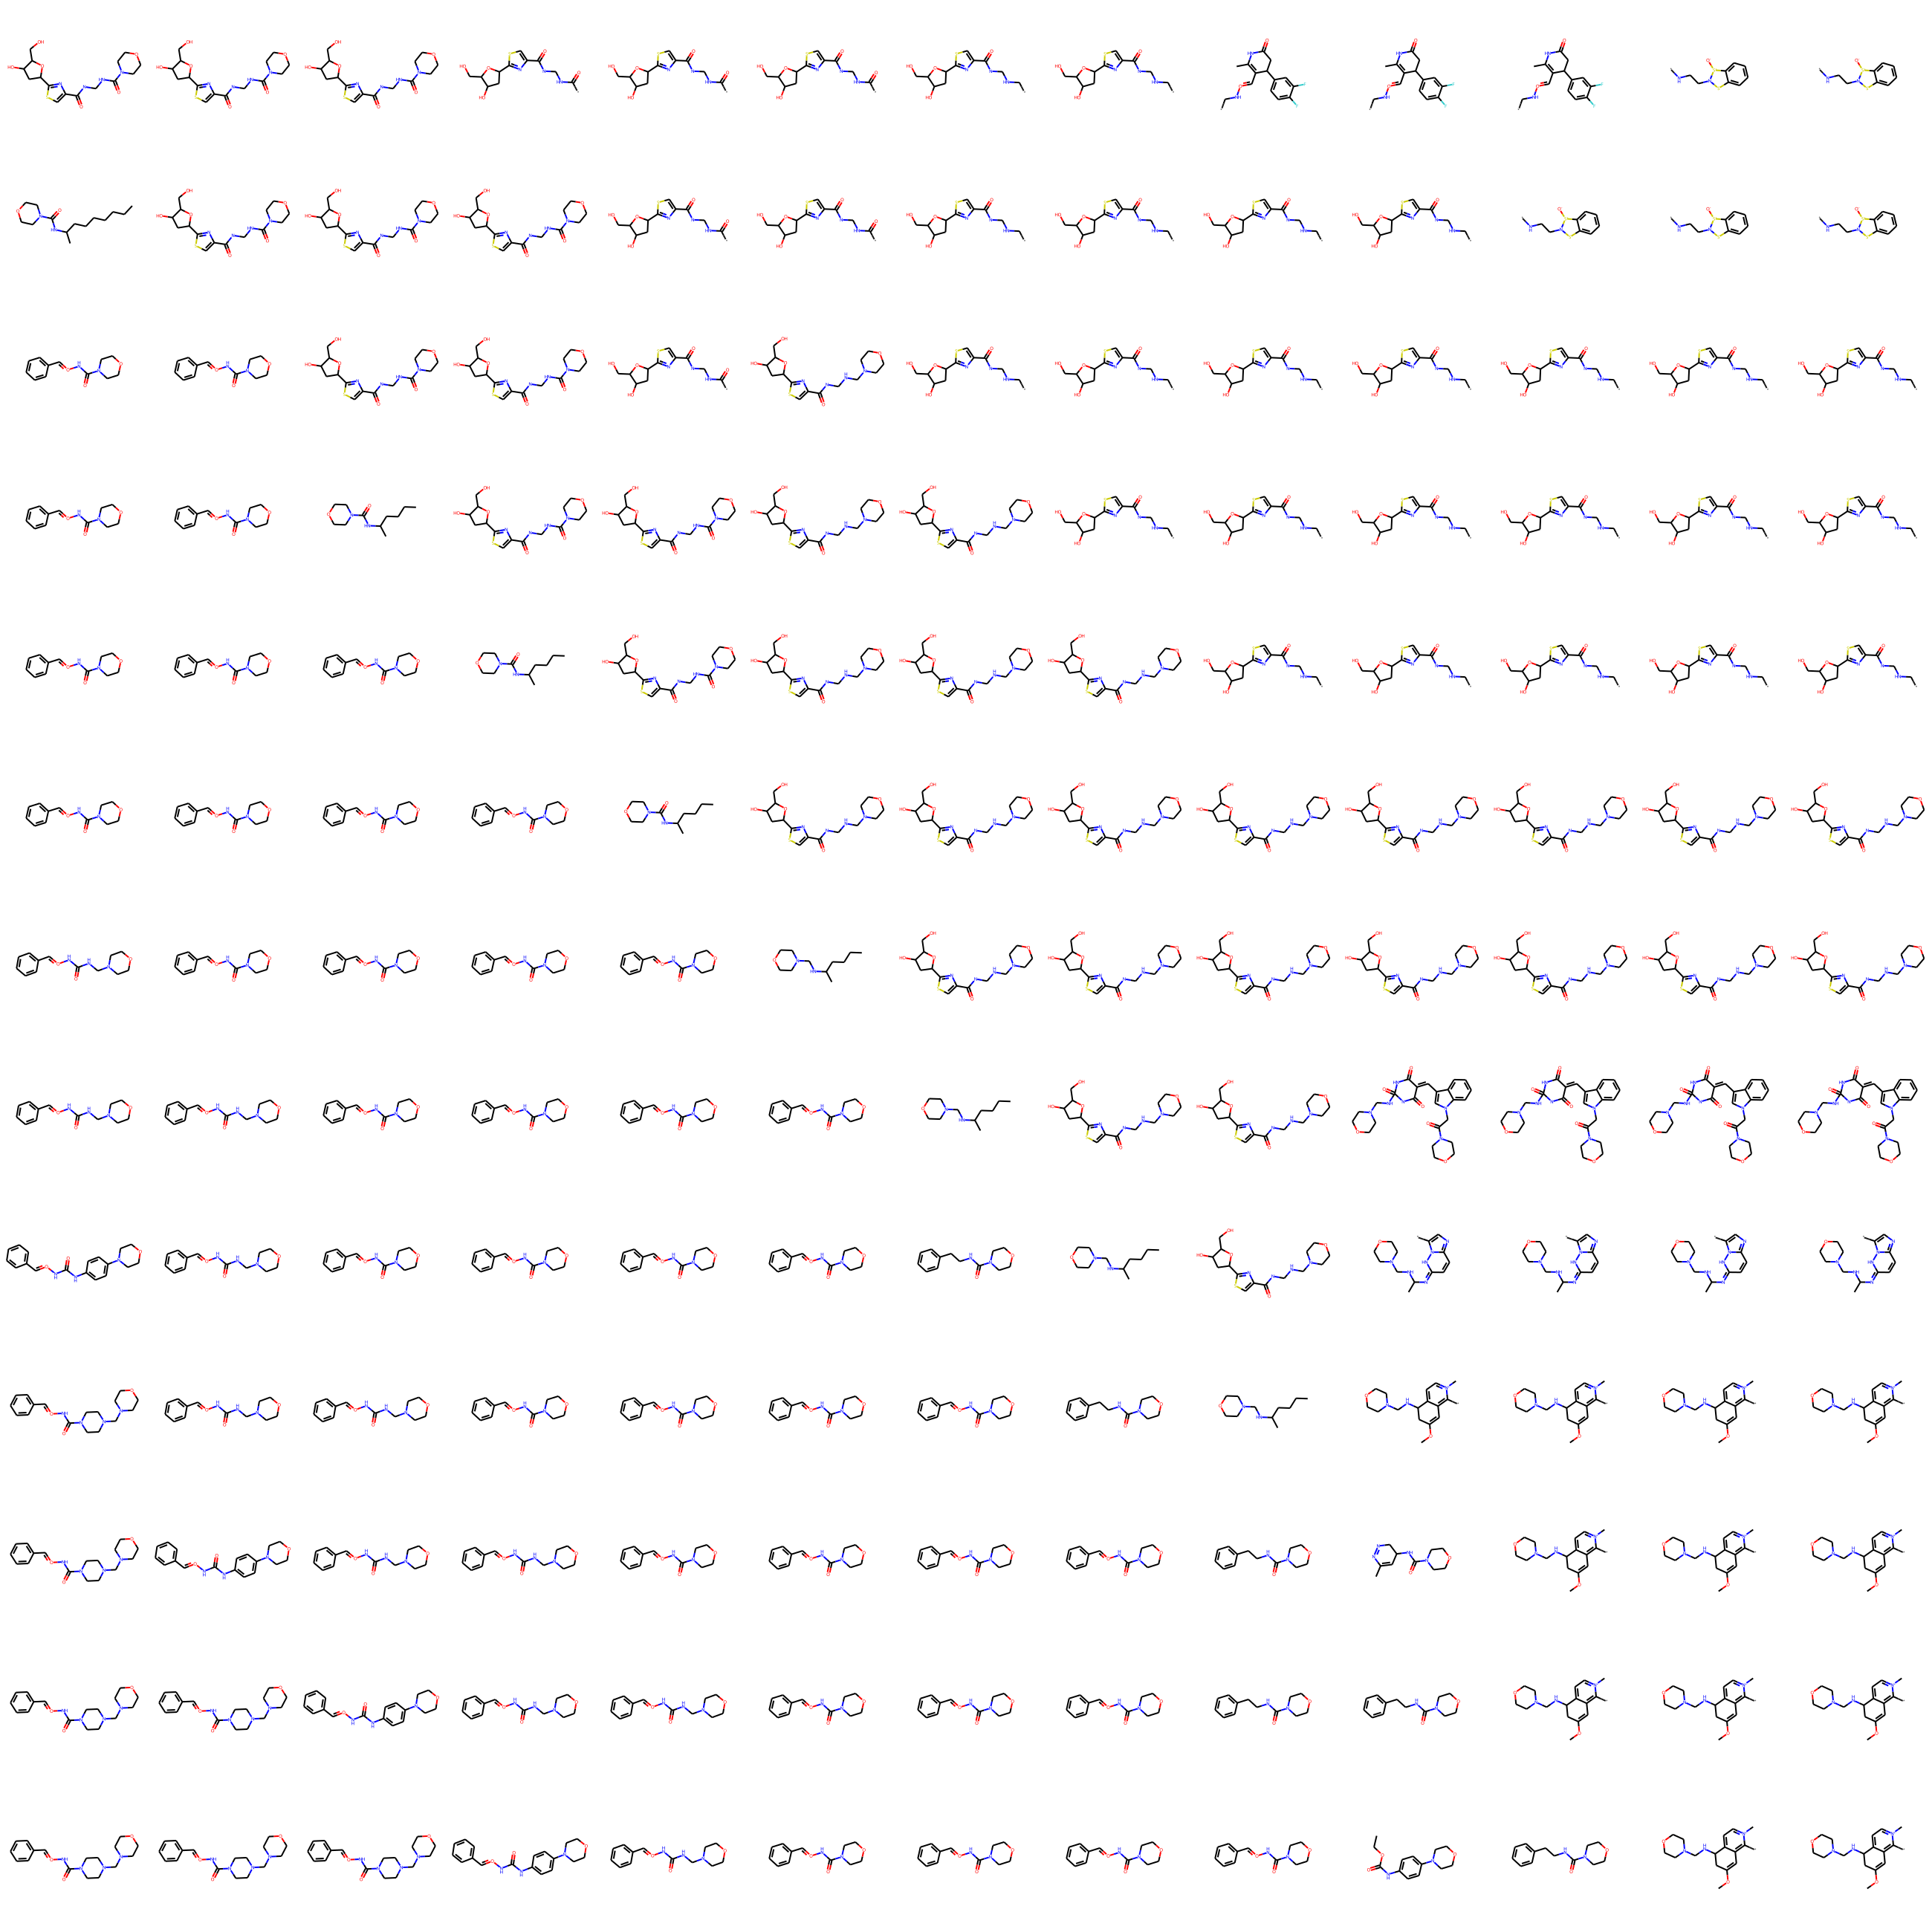

In [360]:
Draw.MolsToGridImage(mol_list, molsPerRow=13, maxMols=999999)

# Check Reconstruction

In [67]:
dataset.data

smiles  \
0       CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...   
1             Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1   
2       COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...   
3       Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...   
4       CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...   
...                                                   ...   
117018     CCN1CCN(C(=O)c2cc(S(=O)(=O)N3CCCCC3)ccc2Cl)CC1   
117019           NC1=NC(c2cccc(NC(=O)c3ccc(Cl)cn3)c2)CCS1   
117020  Cc1ccc(-c2cccc(-c3cnc(N)c(C(=O)N=c4cc[nH]cc4)c...   
117021   O=C(Nc1ccc(S(=O)(=O)Nc2ccccc2)cc1)c1ccc(O)c(O)c1   
117022          CS(=O)(=O)NCCCNc1c2c3ccccc3nc-2oc2ccccc12   

                                                fragments  n_fragments   C  F  \
0       *CCC *N(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O *CC...          5.0  26  0   
1       *c1ccc(O)cc1 *NC(=S)N1N=C(c2ccccc2)CC1* *c1ccccc1          3.0  22  0   
2       *OC *C(*)=O *c1cc(C(=*)c2cc(Cl)c(OC)c(C(=O)OC)...          4.0  25  0   
3       *c1cc(C)nc2ccccc12 *CO* *c1ccc(*)cc1 *N* *C(*)...          7.0  25  0   
4       *CC *O* *C(*)=O *c1ccc(O)c(*)c1 *c1c2c(=O)n(C)...          6.0  23  0   
...                                                   ...          ...  .. ..   
117018  *CC *N1CCN(*)CC1 *C(*)=O *c1cc(S(*)(=O)=O)ccc1...          5.0  18  0   
117019  *C1CCSC(N)=N1 *c1cccc(*)c1 *N* *C(*)=O *c1ccc(...          5.0  16  0   
117020  *c1ccc(C)cc1 *c1cccc(*)c1 *c1cnc(N)c(*)c1 *C(=...          4.0  24  0   
117021  *C(=O)c1ccc(O)c(O)c1 *N* *c1ccc(S(*)(=O)=O)cc1...          5.0  19  0   
117022  *S(C)(=O)=O *N* *CCC* *N* *c1c2c3ccccc3nc-2oc2...          5.0  19  0   

        N  O  Other  SINGLE  DOUBLE  TRIPLE  Tri  Quad  Pent  Hex     logP  \
0       3  5      0      26      10       0    0     0     0    3  2.33400   
1       3  1      1      19      11       0    0     0     1    3  4.94030   
2       0  7      3      26      10       0    0     0     0    2  6.07540   
3       4  4      0      26      10       0    0     0     0    4  3.13402   
4       3  5      0      23      11       0    0     0     1    3  2.57720   
...    .. ..    ...     ...     ...     ...  ...   ...   ...  ...      ...   
117018  3  3      2      22       6       0    0     0     0    3  2.29230   
117019  4  1      2      17       8       0    0     0     0    3  3.48000   
117020  4  1      0      19      13       0    0     0     0    4  4.37542   
117021  2  5      1      17      12       0    0     0     0    3  3.15090   
117022  3  3      1      19      10       0    0     0     1    3  3.43700   

              mr       qed       SAS  
0       128.6249  0.522569  3.595745  
1       112.9455  0.638566  2.563412  
2       138.1390  0.264467  2.973098  
3       124.9069  0.395442  3.145495  
4       116.8143  0.513201  2.494430  
...          ...       ...       ...  
117018  102.0793  0.778914  2.007569  
117019   95.0806  0.891135  3.008976  
117020  114.9446  0.553252  2.761683  
117021  101.4173  0.504472  1.809538  
117022  104.0902  0.508754  2.374712  

[117023 rows x 19 columns]

In [98]:
# Sampling from the prior
mol_list = []
frag_list = []
max_length = config.get('max_length')
temperature = config.get('temperature')
batch_size = 1
counter = 0
with torch.no_grad():
    for z in tqdm(z_stack):
        model_vae = model.cpu()
        model_vae.eval()
        samples, sampled = [], 0
        z = z.cpu()
        #z = model.encoder.sample_normal(1).cpu()
        #z = torch.normal(0, sample_var, size=(1, batch_size, 100))
        #z = mu_stack[10,None,None].cpu()
        #z = mu[None, None, :].cpu()
        state = model_vae.latent2rnn(z)
        state = state.view(model_vae.hidden_layers, batch_size, model_vae.hidden_size)
        # all idx of batch
        sequence_idx = torch.arange(0, batch_size).long()

        # all idx of batch which are still generating
        running = torch.arange(0, batch_size).long()
        sequence_mask = torch.ones(batch_size, dtype=torch.bool)

        # idx of still generating sequences
        # with respect to current loop
        running_seqs = torch.arange(0, 1).long()
        lengths = [1] * batch_size

        generated = torch.Tensor(batch_size, max_length).long()
        generated.fill_(vocab.PAD)

        inputs = Variable(torch.Tensor(batch_size).long())
        inputs.fill_(vocab.SOS).long()
        step = 0
        while(step < max_length and len(running_seqs) > 0):
            inputs = inputs.unsqueeze(1)
            emb = model_vae.embedder(inputs)
            scores, state = model_vae.decoder(emb, state, lengths)
            scores = scores.squeeze(1)

            probs = F.softmax(scores / temperature, dim=1)
            inputs = torch.argmax(probs, 1).reshape(1, -1)

            # save next input
            generated = update(generated, inputs, running, step)
            # update global running sequence
            sequence_mask[running] = (inputs != vocab.EOS)
            running = sequence_idx.masked_select(sequence_mask)

            # update local running sequences
            running_mask = (inputs != vocab.EOS)
            running_seqs = ~running_seqs.masked_select(running_mask)

            # prune input and hidden state according to local update
            run_length = len(running_seqs)
            if run_length > 0:
                inputs = inputs.squeeze(0)
                inputs = inputs[running_seqs]
                state = state[:, running_seqs]
                running_seqs = torch.arange(0, run_length).long()

            lengths = [1] * run_length
            step += 1
        new_samples_torch = generated
        new_samples = generated.numpy()
        #print(vocab.translate(new_samples[0]))
        mask = np.apply_along_axis(row_filter, 1, new_samples)
        #save molecule
            
        try:
            frags = mols_from_smiles(vocab.translate(new_samples[0]))
            mol = join_molecules(frags[0], frags[1])
            for j, frag in enumerate(frags[2:]):
                #print(i, mol_to_smiles(frag), mol_to_smiles(mol))
                mol = join_molecules(mol, frag)
                #print(i, mol_to_smiles(mol))
                mol = mols_from_smiles(mols_to_smiles([mol]))[0]
            model = model.cuda()

            # Store fragments and molecule sampled from the sampled z
            frag_list.append(vocab.translate(new_samples[0]))
            mol_list.append(mol)
        except:
            frag_list.append([None])
            mol_list.append(None)

        counter += 1
        if counter % 500 ==0:
            print(len(mol_list))
            #break
        if counter % 2000 == 0:
            clear_output(wait=True)

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 116000/117023 [49:48<00:28, 36.04it/s][23:03:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:12] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:12] Explicit valence for atom # 11 O, 3, is greater than permitted
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 116004/117023 [49:48<00:28, 35.17it/s][23:03:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:12] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|█████████████████████████████████████████

[23:03:15] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 116142/117023 [49:51<00:22, 39.20it/s][23:03:15] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:15] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:16] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 116146/117023 [49:52<00:25, 34.06it/s][23:03:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:16] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:16] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:16] Explicit valence for atom # 2 O, 3,

[23:03:17] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:17] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 116215/117023 [49:53<00:20, 38.48it/s][23:03:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:17] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:18] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 116219/117023 [49:54<00:29, 26.87it/s][23:03:18] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:18] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:18] Explicit valence for atom # 11 O, 

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 116280/117023 [49:56<00:28, 26.22it/s][23:03:20] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:20] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:20] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 116283/117023 [49:56<00:27, 26.80it/s][23:03:20] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:20] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:20] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:20] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████

[23:03:22] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:22] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:22] Explicit valence for atom # 2 O, 3, is greater than permitted
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 116350/117023 [49:58<00:18, 36.33it/s][23:03:22] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:22] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:22] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:22] Explicit valence for atom # 11 O, 3, is greater than permitted
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 116354/117023 [49:58<00:18, 35.93it/s][23:03:22] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:22] Explicit valence for atom # 2 O,

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 116418/117023 [50:00<00:18, 32.14it/s][23:03:24] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:24] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:24] Explicit valence for atom # 4 O, 3, is greater than permitted
[23:03:24] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:24] Explicit valence for atom # 11 O, 3, is greater than permitted
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 116423/117023 [50:00<00:16, 36.30it/s][23:03:24] Explicit valence for atom # 5 O, 3, is greater than permitted
[23:03:24] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:24] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:24] Explicit valence for atom # 2 O, 3

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 116493/117023 [50:02<00:16, 32.59it/s][23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 116497/117023 [50:02<00:17, 30.41it/s][23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 4 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████

116500


[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 116507/117023 [50:02<00:20, 24.66it/s][23:03:26] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:26] Explicit valence for atom # 11 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 116510/117023 [50:03<00:21, 24.13it/s][23:03:27] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:27] Explicit valence for atom # 5 O, 3, is greater than permitted
[23:03:27] Explicit valence for atom # 2 O, 3,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 116646/117023 [50:06<00:08, 43.14it/s][23:03:30] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:30] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:30] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:30] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:30] Explicit valence for atom # 11 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 116651/117023 [50:06<00:08, 43.21it/s][23:03:30] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:30] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:30] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:30] Explicit valence for atom # 11 O, 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 116721/117023 [50:08<00:07, 42.68it/s][23:03:32] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:32] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:32] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:32] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:32] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 116726/117023 [50:08<00:06, 42.51it/s][23:03:32] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:32] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:32] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:32] Explicit valence for atom # 2 O, 

[23:03:34] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 116797/117023 [50:10<00:04, 46.22it/s][23:03:34] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:34] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:34] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:34] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:34] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 116802/117023 [50:10<00:04, 45.70it/s][23:03:34] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:34] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:34] Explicit valence for atom # 2 O, 3

[23:03:35] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 116872/117023 [50:11<00:03, 40.89it/s][23:03:35] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:35] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:35] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:35] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:35] Explicit valence for atom # 5 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 116877/117023 [50:12<00:03, 41.69it/s][23:03:35] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:36] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:36] Explicit valence for atom # 5 O, 3,

[23:03:37] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 116947/117023 [50:13<00:01, 44.27it/s][23:03:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:37] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:37] Explicit valence for atom # 5 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 116952/117023 [50:13<00:01, 42.85it/s][23:03:37] Explicit valence for atom # 11 O, 3, is greater than permitted
[23:03:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:37] Explicit valence for atom # 2 O, 3,

117000


[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 117012/117023 [50:15<00:00, 42.50it/s][23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:03:39] Explicit valence for atom # 2 O, 3, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 117017/117023

In [102]:
mol_smi_list = []
for mol in tqdm(mol_list):
    if mol == None:
        mol_smi_list.append(None)
    else:
        mol_smi = mols_to_smiles([mol])[0]
        mol_smi_list.append(mol_smi)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117023/117023 [00:00<00:00, 2029430.89it/s]


In [103]:
mol_smi_list

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [110]:
smi_training_list = dataset.data.smiles.to_list()
smi_training_list

['CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O',
 'Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1',
 'COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O)OC)c2)cc(Cl)c1OC',
 'Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2ccccc2n1',
 'CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C)c(=O)n3C)c1',
 'COc1cc(OC)c2c(-c3cccc(-c4ccc(C#N)cc4)c3)cc(=O)oc2c1',
 'COc1cc2[nH]c(C(=O)Nc3ccc(F)cc3)cc2c(OC)c1OC',
 'COc1cc(F)cc(-c2ccc(C(CC(=O)O)NC(=O)C3CCCN3S(=O)(=O)c3cc(Cl)cc(Cl)c3)cc2)c1',
 'COc1cc(-c2cc(OC)c(-n3c(=O)ccc4cc(S(=O)(=O)Nc5cccnn5)ccc43)cc2F)ccc1Cl',
 'CCCCC1(C)CC(CO)C(CCCC)(OC)OO1',
 'CCCCCCCCCCCCNc1ccc2c3c(cccc13)C(=O)N(CCCN1CCCNCCNCCCNCC1)C2=O',
 'COC(=O)C1=C(c2cc3ccccc3o2)CC2CCC1N2C(=O)NCc1cccc2ccccc12',
 'Cc1ccccc1C=Cc1cccc(C(F)(F)P(=O)(O)O)c1',
 'Nc1cc(C2CCNCC2)cc(NC2CCCC2)n1',
 'CCN(C(C)=O)c1ccc(OC)c2nc(NC(=O)C3CCN(C(=O)c4cccc(C(F)(F)F)c4)CC3)sc12',
 'COC(=O)C1CCC(C)C(c2ccc(C)cc2)N1C(=O)c1ccc(C=NOCC(O)COCc2ccco2)cc1',
 'CCOC(=O)C1(Cc2ccccc2C)CCCN(C(=O)CCC(=O)OC)C1',
 'CCCn1c(CN

In [114]:
equiv_mol = []
for i in tqdm(range(len(mol_smi_list))):
    if mol_smi_list[i]==smi_training_list[i]:
        equiv_mol.append(True).append(True)
    else:
        equiv_mol.append(False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117023/117023 [00:00<00:00, 2294413.14it/s]


In [116]:
print(all(item is False for item in equiv_mol))

True


No molecule is correctly reconstructed by the decoder

# Some example molecules

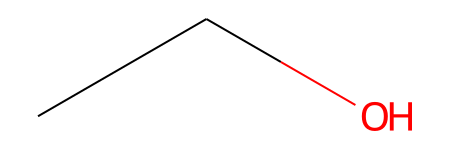

In [14]:
mols_from_smiles(['C(O)C'])[0]

In [38]:
mol = join_molecules(frags[0], frags[1])
for i, frag in enumerate(frags[2:]):
    #print(i, mol_to_smiles(frag), mol_to_smiles(mol))
    mol = join_molecules(mol, frag)
    #print(i, mol_to_smiles(mol))

In [39]:
mol = mols_from_smiles(mols_to_smiles([mol]))[0]

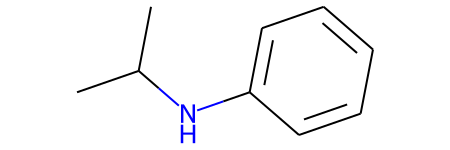

In [40]:
mol

In [41]:
print("logP: ", Crippen.MolLogP(mol))
print("MR: ", Crippen.MolMR(mol))
print("QED: ", QED.qed(mol))
print("SAS: ", calculateScore(mol))

logP:  2.506900000000001
MR:  45.200700000000026
QED:  0.6566219386652469
SAS:  1.4300550809612265


In [232]:
model = model.cuda()
vec_frag_sum = torch.sum(model.embedder(torch.tensor(new_samples).cuda()[torch.tensor(new_samples).cuda() > 2]), 0)
z, mu, sigma = model.encoder(vec_frag_sum)
pred_logp = model.mlp(mu)
pred_logp

tensor([-0.3936], device='cuda:0', grad_fn=<ViewBackward0>)